In [216]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Set random seed
np.random.seed(42)

In [217]:
data = pd.read_csv('data.csv', index_col=0)
data = data[data['weatherCond'].notnull()]

import sklearn.utils
data = sklearn.utils.shuffle(data)

labels = np.ravel(data[['type']],order='C')
data.drop(['userId', 'lat', 'lon', 'location', 'device', 'zip', 'pressure', 'windDeg'],axis=1, inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 838 entries, B5FE9CA4-7080-41CA-9871-7FD90A1D9E75 to E2125D93-B18C-4F1E-AC51-D1F76A803DBD
Data columns (total 9 columns):
clouds         838 non-null int64
date           838 non-null object
humidity       838 non-null int64
temp           838 non-null float64
type           838 non-null int64
visibility     838 non-null int64
weatherCond    838 non-null object
windSpeed      838 non-null float64
zipcode        838 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 65.5+ KB


In [218]:
#force df to have same # of hot / iced rows
hot = data.loc[data.type == 1]
iced = data.loc[data.type == 0]

#remove all hot
data.drop(data[data.type == 1].index, inplace=True)

num_delete = hot.shape[0] - iced.shape[0]
indexes_to_keep = set(range(hot.shape[0])) - set(range(num_delete))
hot_sliced = hot.take(list(indexes_to_keep))

data = pd.concat([data, hot_sliced])
data['type'].value_counts()
labels = np.ravel(data[['type']],order='C')


In [219]:
print("iced", data[data['type']==0].shape)
print("hot",data[data['type']==1].shape)
# data.drop(['type'],axis=1, inplace=True)



iced (312, 9)
hot (312, 9)


In [220]:
def to_bins(col, bins, lables):
    data[col] = pd.cut(data[col], bins=bins, labels=lables)
    return data[col]

def to_categorical(data, cat_vars):
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1=data.join(cat_list)
        data=data1
    data = data.drop(cat_vars, axis=1)
    return data

#convert visibilty from meters to miles
def miles(meter):
    return round(meter/1609.344)

#round data
def round(df):
    return df.apply(lambda x: np.rint(x))

from sklearn.preprocessing import LabelEncoder

def labelEncoder(feature_name):
    return labelencoder.fit_transform(data[feature_name])

In [221]:
data['temp'] = round(data['temp'])
data['windSpeed'] = round(data['windSpeed'])
data['visibility'] = miles(data['visibility'])

In [222]:
#feature engineering with date

#make cols based on:
#day_of_week
#is_weekday
#is_weekend
#morning
#afternoon
#evening

from datetime import datetime
from dateutil import parser

day_of_week = lambda x: parser.parse(x).weekday()
is_weekend = lambda x: parser.parse(x).weekday() > 5
month = lambda x: parser.parse(x).month


def season_of_date(date_str):
    month =  parser.parse(date_str).month
    return (
        "spring" if month >=2 and month <=5
        else
        "summer" if month >=6 and month <=8
        else
        "fall" if month >=9 and month <=11
        else
        "winter"
    )


def get_part_of_day(hour):
    return (
        "morning" if 5 <= hour <= 11
        else
        "afternoon" if 12 <= hour <= 17
        else
        "evening" if 18 <= hour <= 22
        else
        "night"
    )


part_of_day = lambda x: get_part_of_day(parser.parse(x).hour)
data['part_of_day'] =  data['date'].map(part_of_day)

data['day_of_week'] =  data['date'].map(day_of_week)
data['is_weekend'] =  data['date'].map(is_weekend)


data['season'] = data['date'].map(season_of_date)

data = to_categorical(data, cat_vars=['season'])
data = to_categorical(data, cat_vars=['part_of_day'])
# data['is_weekend'] = labelEncoder('is_weekend')




In [223]:
data.head()

,clouds,date,humidity,temp,type,visibility,weatherCond,windSpeed,zipcode,day_of_week,is_weekend,season_fall,season_spring,season_summer,season_winter,part_of_day_afternoon,part_of_day_evening,part_of_day_morning,part_of_day_night
A273F270-DE31-45C0-B77F-0EF8DE909861,75,2018-04-09T11:40:11.795Z,100,72.0,0,10.0,Clouds,4.0,34117,0,False,0,1,0,0,0,0,1,0
73161280-6086-11e7-be36-e17cbde4202e,90,2017-07-04T07:00:23.080Z,94,61.0,0,10.0,Overcast,5.0,94103,1,False,0,0,1,0,0,0,1,0
73F14A86-FCF7-4E96-9074-322E52CCB75D,75,2019-01-03T21:45:31.569Z,68,25.0,0,6.0,Clouds,14.0,05-831,3,False,0,0,0,1,0,1,0,0
465179C2-EAAB-447E-B88A-1070AC66155D,40,2018-07-11T11:05:04.083Z,73,70.0,0,10.0,Fog,9.0,10923,2,False,0,0,1,0,0,0,1,0
7B250E85-9B8F-49A3-AA57-BB71C354FDE9,40,2018-04-05T20:01:18.509Z,58,84.0,0,10.0,Clouds,13.0,34117,3,False,0,1,0,0,0,1,0,0


In [224]:
data['weatherCond']
for index,rows in data.iterrows():
    if ("cloud" in data.loc[index, 'weatherCond'].lower() or "overcast" in data.loc[index, 'weatherCond'].lower()):
        data.loc[index, 'weatherCond'] = 'Clouds'
        
    if ("snow" in data.loc[index, 'weatherCond'].lower()):
        data.loc[index, 'weatherCond'] = 'Snow'
        
    if ("rain" in data.loc[index, 'weatherCond'].lower() or "drizzle" in data.loc[index, 'weatherCond'].lower() or "mist" in data.loc[index, 'weatherCond'].lower()):
        data.loc[index, 'weatherCond'] = 'Rain'
        
    if ("none" in data.loc[index, 'weatherCond'].lower()):
        data.loc[index, 'weatherCond'] = 'Clear'
    

data['weatherCond'].value_counts()

Clouds          236
Rain            172
Clear           168
Fog              22
Haze             14
Snow              6
Thunderstorm      4
Smoke             2
Name: weatherCond, dtype: int64

In [225]:
# one- hot encoding
cat_vars=['weatherCond']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
data = data.drop(['weatherCond'], axis=1)
data.head()

,clouds,date,humidity,temp,type,visibility,windSpeed,zipcode,day_of_week,is_weekend,...,part_of_day_morning,part_of_day_night,weatherCond_Clear,weatherCond_Clouds,weatherCond_Fog,weatherCond_Haze,weatherCond_Rain,weatherCond_Smoke,weatherCond_Snow,weatherCond_Thunderstorm
A273F270-DE31-45C0-B77F-0EF8DE909861,75,2018-04-09T11:40:11.795Z,100,72.0,0,10.0,4.0,34117,0,False,...,1,0,0,1,0,0,0,0,0,0
73161280-6086-11e7-be36-e17cbde4202e,90,2017-07-04T07:00:23.080Z,94,61.0,0,10.0,5.0,94103,1,False,...,1,0,0,1,0,0,0,0,0,0
73F14A86-FCF7-4E96-9074-322E52CCB75D,75,2019-01-03T21:45:31.569Z,68,25.0,0,6.0,14.0,05-831,3,False,...,0,0,0,1,0,0,0,0,0,0
465179C2-EAAB-447E-B88A-1070AC66155D,40,2018-07-11T11:05:04.083Z,73,70.0,0,10.0,9.0,10923,2,False,...,1,0,0,0,1,0,0,0,0,0
7B250E85-9B8F-49A3-AA57-BB71C354FDE9,40,2018-04-05T20:01:18.509Z,58,84.0,0,10.0,13.0,34117,3,False,...,0,0,0,1,0,0,0,0,0,0


In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, A273F270-DE31-45C0-B77F-0EF8DE909861 to 55D67E58-555C-43D6-AAB4-B1A478EC1DCE
Data columns (total 26 columns):
clouds                      624 non-null int64
date                        624 non-null object
humidity                    624 non-null int64
temp                        624 non-null float64
type                        624 non-null int64
visibility                  624 non-null float64
windSpeed                   624 non-null float64
zipcode                     624 non-null object
day_of_week                 624 non-null int64
is_weekend                  624 non-null bool
season_fall                 624 non-null uint8
season_spring               624 non-null uint8
season_summer               624 non-null uint8
season_winter               624 non-null uint8
part_of_day_afternoon       624 non-null uint8
part_of_day_evening         624 non-null uint8
part_of_day_morning         624 non-null uint8
part_of_day_night         

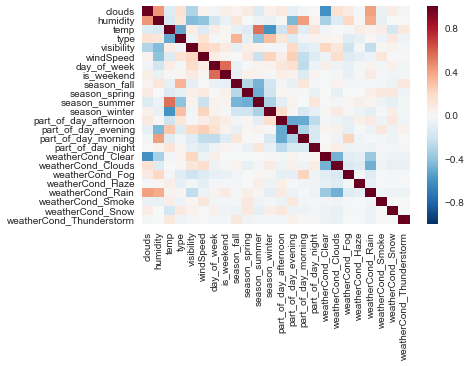

In [227]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [228]:
#save the modified csv
data.to_csv('coffeeBotData-Cleaned.csv')

In [229]:
data.drop(['type', 'date','zipcode'],axis=1, inplace=True)

In [230]:
print("final features")
print(data.info())

final features
<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, A273F270-DE31-45C0-B77F-0EF8DE909861 to 55D67E58-555C-43D6-AAB4-B1A478EC1DCE
Data columns (total 23 columns):
clouds                      624 non-null int64
humidity                    624 non-null int64
temp                        624 non-null float64
visibility                  624 non-null float64
windSpeed                   624 non-null float64
day_of_week                 624 non-null int64
is_weekend                  624 non-null bool
season_fall                 624 non-null uint8
season_spring               624 non-null uint8
season_summer               624 non-null uint8
season_winter               624 non-null uint8
part_of_day_afternoon       624 non-null uint8
part_of_day_evening         624 non-null uint8
part_of_day_morning         624 non-null uint8
part_of_day_night           624 non-null uint8
weatherCond_Clear           624 non-null uint8
weatherCond_Clouds          624 non-null uint8
weatherCond_F

In [231]:
print("data",data.shape)
print("labels", labels.shape)

data (624, 23)
labels (624,)


In [232]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model, 4)
rfe = rfe.fit(data, labels)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False  True False False  True False
 False False False False False  True False False False  True False]
[20 17 13 15 14 18  7  1  5 19  1 12  3 11  4  9 10  1 16  8  6  1  2]


In [233]:
X = data#data[['lat','lon', 'temp', 'windSpeed']]
y = labels
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [234]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.835


In [235]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [236]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(y_test, rf.predict(X_test))))

Random Forest Accuracy: 0.814


In [237]:
#SVM
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print('Support vector machine accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test))))              

Support vector machine accuracy: 0.686


In [238]:
from sklearn import model_selection as ms
from sklearn.model_selection import cross_val_score
scoring = 'accuracy'


kfoldMean = ms.cross_val_score(svc, X_train, y_train, cv = ms.KFold(), scoring=scoring).mean()
Kfold_shuggle = ms.cross_val_score(svc, X_train, y_train, cv = ms.KFold(shuffle = True), scoring=scoring).mean()
print(kfoldMean)
print(Kfold_shuggle)

0.6445126751692646
0.6307353172728704


In [239]:
#save mode
import pickle
# filename = 'svc.sav'
filename = 'models/rf.sav'
pickle.dump(rf, open(filename, 'wb'), protocol=2)

In [240]:

#save mode
import pickle
filename = 'models/logreg.sav'
# filename = 'rf.sav'
pickle.dump(logreg, open(filename, 'wb'), protocol=2)

In [ ]:
file = open(filename, 'rb')
svc = pickle.load(file)
svc